<a id="start"></a>
* [Презентация](https://disk.yandex.ru/d/4cuHNdpZPqIlhQ)
* [Дашборд](https://public.tableau.com/views/_16984828165280/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)
* [Дашборд резервная ссылка](https://public.tableau.com/app/profile/arseniy4456/viz/FinalprojectGaman/Dashboard1)

# Анализ эффективности операторов

### Цель исследования:
* На основании имеющихся данных определить какие операторы неэффективны про указанным заказчиком критериям.
* Предложить методику, по которой этот процесс можно было бы автоматизировать.
* Проверка гипотезы: Неэффективные операторы работают меньше дней в месяц, чем эффективные.
* Проверка гипотезы: Неэффективные операторы чаще совершают внутренние звонки (например, чтобы уточнить что-то у коллег).

### Содержание:

* [Загрузка данных](#part1)
* [Предобработка данных](#part2)
    * [Обработка пропусков](#part2-1)
    * [Изменение типа данных](#part2-2)
    * [Удаление дубликатов](#part2-3)
* [Исследовательский анализ данных](#part3)
    * [Пропущенные звонки](#part3-1)
    * [Время ожидания](#part3-2)
    * [Количество исходящих звонков](#part3-3)
    * [Оценка эффективности операторов](#part3-4)
* [Проверка гипотез](#part4)
    * [Рабочие дни](#part4-1)
    * [Внутренние звонки](#part4-2)
* [Выводы](#part5)


<a id="part1"></a>
## Загрузка данных и знакомство с данными

In [1]:
pip install matplotlib --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
from scipy import stats as st

In [3]:
telecom = pd.read_csv('/datasets/telecom_dataset.csv')
display(telecom.head(15))
telecom.info()
display(telecom.duplicated().sum())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


4900

* Пропуски
    * Имеются пропуски в идентификаторе оператора. Их я полностью уберу из датасета так как айди оператора - ключевой параметр исследования. Причиной этому может быть то, что клиенты сбрасывали вызов до того, как им был присвоен оператор.
    * Пропуски в маркере внутренних звонков тоже удалю, так как их количество невелико.
* Тип данных
    * Столбец с датой требует конвертации в тип данных datetime.
    * Столбец с внутренними вызовами имеет неверный тип данных, требует конвертации в bool.
    * Столбец с направлением для удобства переконвертирую в bool.
    * Столбец с номером оператора лучше перевести в целочисленный формат для удобства.
* Дубликатов огромное количество, все придется удалить.
<br>
<br>
Качество данных приемлемое, требует несерьезных измемнений.

<a id="part2"></a>
## Предобработка данных

### Обработка пропусков
<a id="part2-1"></a> 

In [4]:
temp = telecom.copy() # создаю копию датасета до преобразования

In [5]:
# Удаляю пропуски у индентификатора оператора
telecom = telecom.dropna(subset=['operator_id'])
telecom = telecom.dropna(subset=['internal']).reset_index(drop=True)

In [6]:
#Узнаю сколько я выбросил процентов строк
a, b = len(temp), len(telecom)
print(a, b, round((a-b)/a*100, 2)) 

53902 45670 15.27


### Изменение типа данных
<a id="part2-2"></a>

In [7]:
telecom['dt_date'] = pd.to_datetime(telecom['date'], format='%Y-%m-%d %H:%M:%S+03:00')

#display(telecom['direction'].value_counts())

#Функции для конвертации в булевый тип
def direction_to_bool(row):
    #если в ячейке out то возвращает True, если in то False
    dir_row = row['direction']
    try:
        if dir_row == 'out':
            return True
        else:
            return False
    except: 
        return False
        
telecom['out_direction'] = telecom.apply(direction_to_bool, axis = 1) #Применяю функцию чтобы создать столбец с булевыми значениями направления звонка

telecom['internal'] = telecom['internal'].astype('bool') #Изменяю тип данных internal
telecom['operator_id'] = telecom['operator_id'].astype('int') #Изменяю тип данных operator_id

telecom.info()
display(telecom.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45670 entries, 0 to 45669
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45670 non-null  int64         
 1   date                 45670 non-null  object        
 2   direction            45670 non-null  object        
 3   internal             45670 non-null  bool          
 4   operator_id          45670 non-null  int64         
 5   is_missed_call       45670 non-null  bool          
 6   calls_count          45670 non-null  int64         
 7   call_duration        45670 non-null  int64         
 8   total_call_duration  45670 non-null  int64         
 9   dt_date              45670 non-null  datetime64[ns]
 10  out_direction        45670 non-null  bool          
dtypes: bool(3), datetime64[ns](1), int64(5), object(2)
memory usage: 2.9+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,dt_date,out_direction
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,True
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,2019-08-05,True
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,2019-08-05,True


### Удаление дубликатов
<a id="part2-3"></a>

In [8]:
telecom = telecom.drop_duplicates(keep='first').reset_index(drop=True)
display(telecom.duplicated().sum())
#telecom.info()

0

<a id="part3"></a>
## Исследовательский анализ данных

### Доля пропущенных звонков
<a id="part3-1"></a>

,operator_id,missed_percent
0,880022,0.0
1,880020,0.0
2,881278,NaN
3,880028,0.0
4,880026,0.0


Порог эффективности по количеству пропущенных звонков: 9%


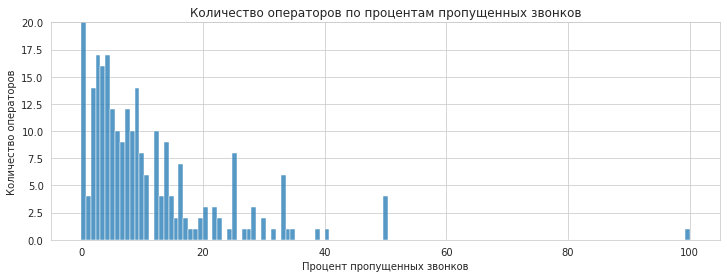

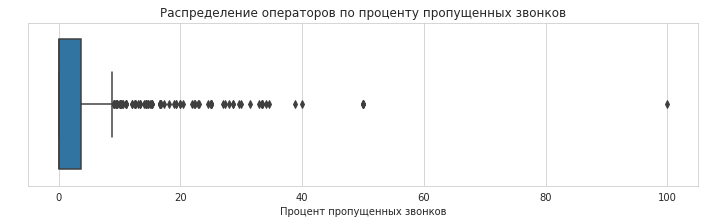

In [9]:
# Фильтрую только входящие внешние звонки
telecom_miscall = telecom.query('out_direction == False and internal == False')
#display(telecom_miscall.head())

# Таблица с суммой всех звонков и всех пропущенных звонков для каждого оператора
telecom_miscall = telecom_miscall.pivot_table(index='operator_id', aggfunc=['count','sum'], values='is_missed_call').reset_index().droplevel(1, axis=1)
telecom_miscall.columns = ['operator_id', 'calls','missed_calls']
#display(telecom_miscal.head(10))

# Процент пропущенных звонков для каждого оператора
telecom_miscall['missed_percent'] = ((telecom_miscall['missed_calls'] / telecom_miscall['calls'])*100).round(2)
#display(telecom_miscal.head(10))

# Готовлю таблицу по которой буду считать рейтинг операторов
operator_rating = telecom['operator_id'].unique()
operator_rating = pd.DataFrame(operator_rating, columns=['operator_id']) 

# Соединяю таблицы
telecom_miscall = telecom_miscall.drop(['calls','missed_calls'], axis=1)
operator_rating = operator_rating.merge(telecom_miscall, on='operator_id', how='left')
display(operator_rating.head())

#Высчитываю порог эффективности и строю графики
miscall_threshold = (((operator_rating['missed_percent'].describe()['75%'])-
                     (operator_rating['missed_percent'].describe()['25%']))*1.5+
                     operator_rating['missed_percent'].describe()['75%']).round().astype('int')

print(f'Порог эффективности по количеству пропущенных звонков: {miscall_threshold}%')


plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
tch2 = sns.histplot(x='missed_percent', data = operator_rating)
tch2.set_xlabel('Процент пропущенных звонков')
tch2.set_ylabel('Количество операторов')
tch2.set_title('Количество операторов по процентам пропущенных звонков')
#plt.savefig('hist misscall.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
tch2.set(ylim=(0, 20))
plt.show(tch2);

plt.figure(figsize=(12,3))
ax = sns.boxplot(x='missed_percent', data=operator_rating)
#ax.set_ylim(0, 2.5)
ax.set_ylabel(' ')
ax.set_xlabel('Процент пропущенных звонков')
ax.set_title('Распределение операторов по проценту пропущенных звонков')
#plt.savefig('box misscall.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

Видно что есть один оператор который проигнорировал все входящие звонки.
<br>
Исходя из графика, будем считать больше <b>9%</b> пропущенных звонков одним из признаков неэффективности (Q3+1.5*IQR).

### Доля ожидания ответа оператора
<a id="part3-2"></a>

Посчитать эффективность оператора по времени ожидания можно несколькими способами:
* По аналогии с предыдущим пунктом для каждого оператора сложить общее время звонков и посчитать какой процент от этого времени занимает ожидание. Признать неэффективными тех, у кого такой процент будет выше наблюдаемоного максимума (> чем Q3+1.5*IQR).
    * Проблема в том, что оценка времени ожидания будет зависеть от времени разговора и таким образом не будет объективной в случае, например, если разговор продлиться не долго. Например клиент будет ожидать ответа 10 секунд а разговор тоже продлиться 10, и вроде как ждал клиент недолго, но показатель будет очень плохим для оператора.
    * С другой стороны при таком расчете я ориентируюсь на показатель наблюдаемого максимума процента ожидания среди всех операторов, и тогда, если ситуация описанная выше будет случаться у всех операторов достаточно часто, то такой показатель не будет признан неэффективным.
* Посчитать медиану времени ожидания для всех входящих внешних непропущенных звонков для каждого оператора. Признать неэффективными тех, у кого медиана времени ожидания будет выше наблюдаемоного максимума (> чем Q3+1.5*IQR).
    * Медиана покажет более объективную ситуацию так как будет учитывать не самое частовстречающееся соотношение ожидания и раговора у каждого оператора, а именно само медианное время.
    * В предоставленном датасете нет показателя ожидания для КАЖДОГО разговора, есть только показатель СУММАРНОГО времени ожидания для каждого дня. Получается, что тогда будет сравниваться медиана суммарного времени ожидания в день для каждого оператора. Это сново добавит необъективности, так как в некоторые дни может случайно получаться ситуация описанная в первом подпункте первого пункта выше, с другой стороны медиана должна игнорировать такие выбросы.
<br>
<br>
Я применю оба способа и выберу лучший.

#### Процент суммы времени ожидания от суммы всех звонков для каждого оператора

In [10]:
# Фильтрую только входящие внешние непропущенные звонки
telecom_waiting = telecom.query('out_direction == False and internal == False and is_missed_call == False')

# Таблица с суммой времени всех звонков и всех звонков с ожиданием
telecom_waiting_sum = telecom_waiting.groupby('operator_id')['total_call_duration', 'call_duration'].sum().reset_index()

# Столбец с процентом суммы ожидания на линии от суммы времени звонка за все время
telecom_waiting_sum['waiting_percent'] = (100 - ((telecom_waiting_sum['call_duration'] / telecom_waiting_sum['total_call_duration'])*100)).round(2)

telecom_waiting_sum = telecom_waiting_sum.drop(['total_call_duration','call_duration'], axis=1)

display(telecom_waiting_sum.head(10))

/tmp/ipykernel_89/1206225605.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  telecom_waiting_sum = telecom_waiting.groupby('operator_id')['total_call_duration', 'call_duration'].sum().reset_index()


,operator_id,waiting_percent
0,879896,9.27
1,879898,20.85
2,880020,15.30
3,880022,17.95
4,880026,8.27
5,880028,6.37
6,882476,33.10
7,882478,18.57
8,882680,19.64
9,882684,6.75


Порог эффективности по времени ожидания: 53%


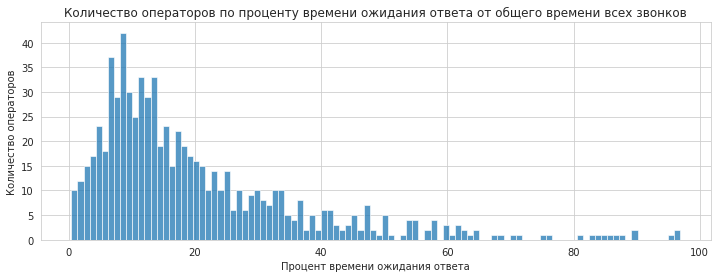

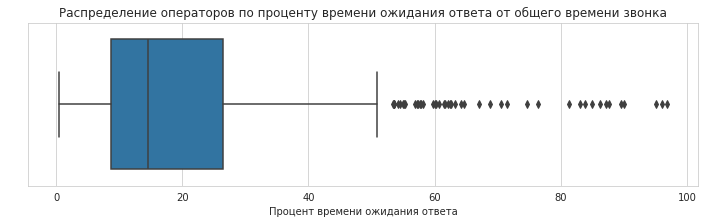

In [11]:
#Высчитываю порог эффективности по Q3 и строю графики

waiting_sum_threshold = (((telecom_waiting_sum['waiting_percent'].describe()['75%'])-
                     (telecom_waiting_sum['waiting_percent'].describe()['25%']))*1.5+
                     telecom_waiting_sum['waiting_percent'].describe()['75%']).round().astype('int')
print(f'Порог эффективности по времени ожидания: {waiting_sum_threshold}%')

plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
tch2 = sns.histplot(x='waiting_percent', data = telecom_waiting_sum, bins=100)
tch2.set_xlabel('Процент времени ожидания ответа')
tch2.set_ylabel('Количество операторов')
tch2.set_title('Количество операторов по проценту времени ожидания ответа от общего времени всех звонков')
#plt.savefig('hist percent waiting.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
#tch2.set(ylim=(0, 20))
plt.show(tch2);

plt.figure(figsize=(12,3))
ax = sns.boxplot(x='waiting_percent', data=telecom_waiting_sum)
#ax.set_ylim(0, 2.5)
ax.set_ylabel(' ')
ax.set_xlabel('Процент времени ожидания ответа')
ax.set_title('Распределение операторов по проценту времени ожидания ответа от общего времени звонка')
#plt.savefig('boc percent waiting.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

#### Медиана времени ожидания всех звонков у каждого оператора

/tmp/ipykernel_89/2417283736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_waiting_med['call_waiting_median'] = telecom_waiting_med['total_call_duration'] - telecom_waiting_med['call_duration']


,operator_id,call_waiting_median
0,879896,16.0
1,879898,14.5
2,880020,7.0
3,880022,16.0
4,880026,6.5


Порог эффективности по медиане времени ожидания: 108 сек.


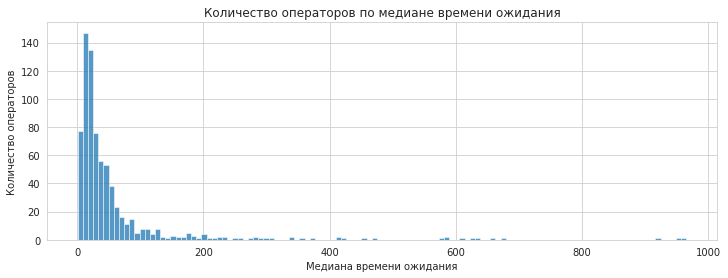

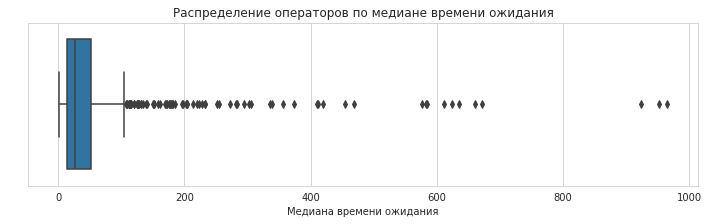

In [12]:
# Фильтрую только входящие внешние непропущенные звонки
telecom_waiting_med = telecom.query('out_direction == False and internal == False and is_missed_call == False')

# Считаю время ожидания для каждой строки
telecom_waiting_med['call_waiting_median'] = telecom_waiting_med['total_call_duration'] - telecom_waiting_med['call_duration']

# Таблица с медианами времени ожидания для каждого оператора
telecom_waiting_med = telecom_waiting_med.groupby('operator_id')['call_waiting_median'].median().reset_index()
display(telecom_waiting_med.head())

# Считаю порогвое значение эффективности
telecom_waiting_med_tr = telecom_waiting_med['call_waiting_median'].describe()
waiting_med_threshold = (((telecom_waiting_med_tr['75%'])-
                     (telecom_waiting_med_tr['25%']))*1.5+
                     telecom_waiting_med_tr['75%']).round().astype('int')
print(f'Порог эффективности по медиане времени ожидания: {waiting_med_threshold} сек.')

# Строю графики
plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
tch2 = sns.histplot(x='call_waiting_median', data = telecom_waiting_med)
tch2.set_xlabel('Медиана времени ожидания')
tch2.set_ylabel('Количество операторов')
tch2.set_title('Количество операторов по медиане времени ожидания')
#plt.savefig('hist median waiting.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show(tch2);

plt.figure(figsize=(12,3))
ax = sns.boxplot(x='call_waiting_median', data=telecom_waiting_med)
ax.set_ylabel(' ')
ax.set_xlabel('Медиана времени ожидания')
ax.set_title('Распределение операторов по медиане времени ожидания')
#plt.savefig('box median waiting.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

Сравнив графики в обеих случаях видно, что при способе с медианой они намного лучше сочетсяются друг с другом - "ус" ящичного графика заканчивается там же, где резко падают значения на гистограмме, в случае с процентами такого не наблюдается.
<br>
Таким образом, исходя из данных, будем считать медиану больше <b>108 секунд</b> времени в ожидании ответа оператора одним из признаков неэффективности и добавим значения медиан в таблицу с рейтингом

In [13]:
#Добавляю медиану ожидания к таблице с процентом пропущенных звонков - это будет таблица с рейтингом по всем параметрам

operator_rating = operator_rating.merge(telecom_waiting_med, on='operator_id', how='left')
display(operator_rating.head())

,operator_id,missed_percent,call_waiting_median
0,880022,0.0,16.0
1,880020,0.0,7.0
2,881278,NaN,NaN
3,880028,0.0,7.0
4,880026,0.0,6.5


### Количество исходящих звонков
<a id="part3-3"></a>

В этой главе я сначала выясню, какие колл-центры сосредоточенны на исходящих звонках. Эффективность по количеству исходящих звонков я буду оценивать только у операторов таких колл-центров.

#### Сосредоточенные на исходящих звонках колл-центры

,user_id,calls,out_calls
0,166377,4999,4897.0
1,166391,4,0.0
2,166392,102,0.0
3,166399,11,0.0
4,166405,11980,9789.0
5,166406,8209,8048.0
6,166407,386,306.0
7,166428,123,0.0
8,166481,1,0.0
9,166482,48,0.0


,user_id,calls,out_calls,out_percent
0,166377,4999,4897.0,97.96
1,166391,4,0.0,0.00
2,166392,102,0.0,0.00
3,166399,11,0.0,0.00
4,166405,11980,9789.0,81.71
5,166406,8209,8048.0,98.04
6,166407,386,306.0,79.27
7,166428,123,0.0,0.00
8,166481,1,0.0,0.00
9,166482,48,0.0,0.00


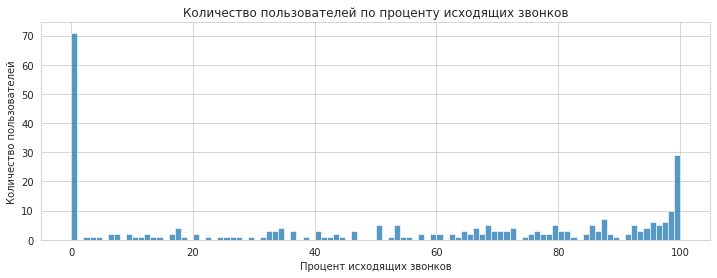

In [14]:
# Считаю для каждого пользователя количество звонков и исходящих звонков
users_spec = telecom.query('internal == False').pivot_table(index='user_id', aggfunc='sum', values='calls_count').reset_index()
users_spec2 = telecom.query('out_direction == True and internal == False').pivot_table(index='user_id', aggfunc='sum', values='calls_count').reset_index()
users_spec.columns = ['user_id', 'calls']
users_spec = users_spec.merge(users_spec2, on = 'user_id', how = 'left').fillna(0)
users_spec.columns = ['user_id', 'calls', 'out_calls']

display(users_spec.head(15))

# Вычисляю процет исходящих звонков
users_spec['out_percent'] = ((users_spec['out_calls'] / users_spec['calls'])*100).round(2)
display(users_spec.head(15))

fig, ax = plt.subplots(figsize=(12, 4))
sns.set_style('whitegrid')
sns.histplot(x='out_percent', data = users_spec, bins=100)
ax.set_xlabel('Процент исходящих звонков')
ax.set_ylabel('Количество пользователей')
ax.set_title('Количество пользователей по проценту исходящих звонков')
#plt.savefig('out calls.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

Будем считать колл-центр специализируещимся на исходящих звонках, если их больше половины

[159, 131]

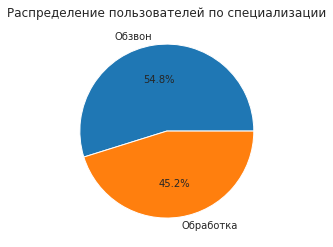

In [15]:
users_spec['spec_out'] = users_spec['out_percent'] > 50

#op_us['users_spec_out'] = op_us['users_spec_out'].astype('bool')

users_spec_pie = [users_spec['spec_out'].sum(), users_spec['spec_out'].count()-users_spec['spec_out'].sum()]
display(users_spec_pie)
labels_users = ['Обзвон','Обработка']
fig1, ax = plt.subplots()
ax.pie(users_spec_pie, labels=labels_users, autopct='%1.1f%%')
ax.set_title('Распределение пользователей по специализации')
#plt.savefig('pie call centers.png', dpi=300.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show()

/tmp/ipykernel_89/2967259504.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_us['users_spec_out'][index] = True
/tmp/ipykernel_89/2967259504.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_us['users_spec_out'][index] = False
/tmp/ipykernel_89/2967259504.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_us['users_spec_out'][index] = False


,user_id,operator_id,users_spec_out
0,166377,880022,True
1,166377,880020,True
2,166377,881278,True
3,166377,880028,True
4,166377,880026,True


[730, 362]

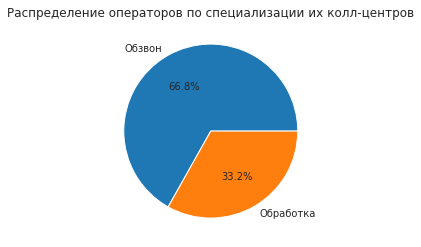

In [16]:
# Оставляем только специлизируещиеся на исходящих звонка колл-центры
users_spec_out = users_spec.query('spec_out == True')
out_ids = list(users_spec_out['user_id'])

# создаю таблицу с парой пользователь-оператор
op_us = telecom.loc[:,['user_id','operator_id']].drop_duplicates(keep='first').reset_index(drop=True)

# Проверяю точно ли у каждого оператора один пользователь
check = op_us.pivot_table(index='operator_id', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)
#display(check.head())

# Проверяю есть ли операторы только с входящими вызовами
only_inn_calls = telecom.query('internal == False')
only_inn_calls = only_inn_calls.loc[:,['out_direction','operator_id']]
only_inn_calls = only_inn_calls.pivot_table(index='operator_id', values='out_direction', aggfunc='sum').query('out_direction == 0').sort_values(by='out_direction', ascending=False).reset_index()
#display(only_inn_calls.head(20))
only_inn_calls2 = list(only_inn_calls['operator_id'])

#Добавляю столбец, где у пользователя, специализирующегося на обзвонах будет значение True
op_us['users_spec_out'] = ""
for index, row in op_us.iterrows():
    if row['operator_id'] in only_inn_calls2:
        op_us['users_spec_out'][index] = False
    elif row['user_id'] in out_ids:
        op_us['users_spec_out'][index] = True  
    else:
        op_us['users_spec_out'][index] = False


display(op_us.head())

op_us['users_spec_out'] = op_us['users_spec_out'].astype('bool')

operators_spec_pie = [op_us['users_spec_out'].sum(), op_us['users_spec_out'].count()-op_us['users_spec_out'].sum()]
display(operators_spec_pie)
labels_users = ['Обзвон','Обработка']
fig1, ax = plt.subplots()
ax.pie(operators_spec_pie, labels=labels_users, autopct='%1.1f%%')
ax.set_title('Распределение операторов по специализации их колл-центров')
#plt.savefig('pie operator call centers.png', dpi=300.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show()

Имеются пропуски в calls_per_day даже когда значение users_spec_out = True. Это те случаи, когда колл-центр специализируется на обзвонах, но конкретный оператор в нем не сделал ни одного исходящего звонка. Для таких случаев поменяю users_spec_out на False

Пользователи поделились ровно на две трети обзвона, и одну треть обработки.

In [17]:
# Присоединяю полученные данные к таблице с рейтингом
operator_rating = operator_rating.merge(op_us, on='operator_id', how='left').drop(['user_id'], axis=1)
display(operator_rating)

#operator_rating.info()

,operator_id,missed_percent,call_waiting_median,users_spec_out
0,880022,0.0,16.0,True
1,880020,0.0,7.0,True
2,881278,NaN,NaN,True
3,880028,0.0,7.0,True
4,880026,0.0,6.5,True
...,...,...,...,...
1087,958394,0.0,11.0,False
1088,952914,0.0,33.0,True
1089,952916,0.0,25.0,True
1090,959118,NaN,NaN,True


#### Количество исходящих звонков в день

Звонки, на которые клиент не ответил, тоже буду учитывать, ведь оператор совершил требуемые действия а ответ клиента от него не зависит.

In [18]:
#display(telecom.head())
#display(operator_rating.head())

# Соединяю таблицы чтобы можно было отфильтровать данные по специализирующимся пользователям
out_calls = telecom.merge(op_us, on='operator_id', how='left')
display(out_calls.head())

,user_id_x,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,dt_date,out_direction,user_id_y,users_spec_out
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True,166377,True
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,166377,True
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,True,166377,True
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,2019-08-05,True,166377,True
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,2019-08-05,True,166377,True


In [19]:
out_calls = out_calls.query('out_direction == True and internal == False and users_spec_out == True')
#display(out_calls.head())

# Считаю количество звонков в день
out_calls_days = out_calls.pivot_table(index=['operator_id','dt_date'] , values='calls_count', aggfunc='sum').reset_index()
out_calls_days = out_calls_days.pivot_table(index='operator_id', values='calls_count', aggfunc=['count','sum']).reset_index().droplevel(1, axis=1)
out_calls_days.columns = ['operator_id', 'days_worked','calls']
out_calls_days['calls_per_day'] = (out_calls_days['calls'] / out_calls_days['days_worked']).round(2)
display(out_calls_days.head(20))
out_calls_days = out_calls_days.drop(['days_worked','calls'], axis=1)

,operator_id,days_worked,calls,calls_per_day
0,879896,48,816,17.00
1,879898,79,7191,91.03
2,880020,7,34,4.86
3,880022,36,174,4.83
4,880026,77,2188,28.42
5,880028,78,2489,31.91
6,880240,5,41,8.20
7,881278,5,12,2.40
8,882684,58,651,11.22
9,882686,77,2876,37.35


Порог эффективности по количеству звонков в день: 3.0 звонка


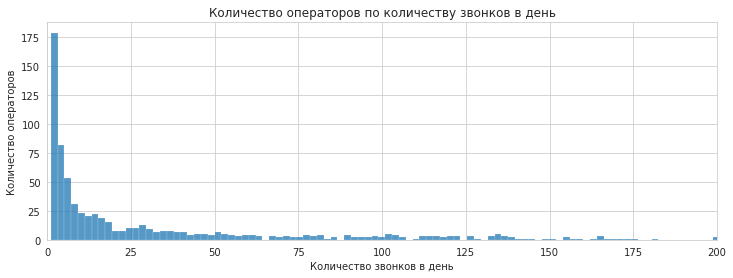

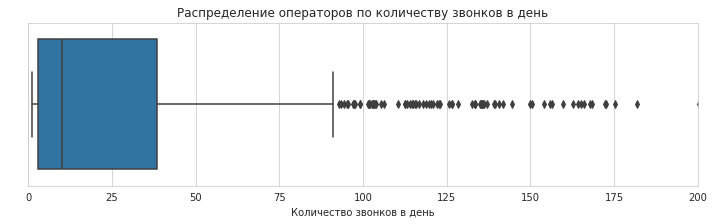

In [20]:
# строю графики и считаю порог
outcalls_threshold = out_calls_days['calls_per_day'].describe()['25%']
print(f'Порог эффективности по количеству звонков в день: {outcalls_threshold} звонка')


fig, ax = plt.subplots(figsize=(12, 4))
sns.set_style('whitegrid')
sns.histplot(x='calls_per_day', data = out_calls_days, bins=400)
ax.set_xlim(0, 200)
ax.set_xlabel('Количество звонков в день')
ax.set_ylabel('Количество операторов')
ax.set_title('Количество операторов по количеству звонков в день')
#plt.savefig('hist calls per day.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

plt.figure(figsize=(12,3))
ax = sns.boxplot(x='calls_per_day', data = out_calls_days)
ax.set_xlim(0, 200)
ax.set_ylabel(' ')
ax.set_xlabel('Количество звонков в день')
ax.set_title('Распределение операторов по количеству звонков в день')
#plt.savefig('box calls per day.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

В данном случае мною решено выбрать в качестве порога q1, равный <b>3</b> звонкам в день. Это отсечет четверть выборки, однако это единственный критерий для операторов которые занимаются обзвоном а не обработкой звонков.

In [21]:
# Добавляю информацию в рейтинг
operator_rating = operator_rating.merge(out_calls_days, on='operator_id', how='left')
display(operator_rating)

,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day
0,880022,0.0,16.0,True,4.83
1,880020,0.0,7.0,True,4.86
2,881278,NaN,NaN,True,2.40
3,880028,0.0,7.0,True,31.91
4,880026,0.0,6.5,True,28.42
...,...,...,...,...,...
1087,958394,0.0,11.0,False,NaN
1088,952914,0.0,33.0,True,30.47
1089,952916,0.0,25.0,True,1.75
1090,959118,NaN,NaN,True,3.50


In [22]:
#Финальный рейтинг
display(operator_rating.head())

,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day
0,880022,0.0,16.0,True,4.83
1,880020,0.0,7.0,True,4.86
2,881278,NaN,NaN,True,2.40
3,880028,0.0,7.0,True,31.91
4,880026,0.0,6.5,True,28.42


Заменю все пропуски в столбцах с характеристиками на -1, это пригодится в дальнейшем.

In [23]:
operator_rating['missed_percent'] = operator_rating['missed_percent'].fillna(-1)
operator_rating['call_waiting_median'] = operator_rating['call_waiting_median'].fillna(-1)
operator_rating['calls_per_day'] = operator_rating['calls_per_day'].fillna(-1)
display(operator_rating.head())

,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day
0,880022,0.0,16.0,True,4.83
1,880020,0.0,7.0,True,4.86
2,881278,-1.0,-1.0,True,2.40
3,880028,0.0,7.0,True,31.91
4,880026,0.0,6.5,True,28.42


### Оценка эффективности оператора
<a id="part3-4"></a>

Предлагаю распределение всех операторов на категории:
* Категория 0:
    * Все показатели такого оператора не выходят за рамки эффективности
    * Показатель обзвона не учитывается, если колл-центр оператора не специализируется на этом.
* Категория 1:
    * Показатель пропущенных звонков <b>или</b> ожидания выходит за пороговое значение.
    * Показатель обзвона не учитывается, если колл-центр оператора не специализируется на этом.
    * Если колл-центр оператора специализируется на обзвонах, то значение обзвонов не выходит за рамки эффективных.
* Категория 2:
    * Показатель пропущенных звонков <b>и</b> ожидания выходит за пороговое значение.
    * Показатель обзвона не учитывается, если колл-центр оператора не специализируется на этом.
    * Если колл-центр оператора специализируется на обзвонах, то значение обзвонов не выходит за рамки эффективных.
* Категория 3:
    * Оператор относится к "обзвонному" колл-центру, и его показатель обзвонов неэффективен.
    * Остальные показатели в норме.
* Категория 4:
    * Оператор относится к "обзвонному" колл-центру, и его показатель обзвонов неэффективен.
    * Один из других показателей выходит за пороговое значение
* Категория 5:
    * Оператор относится к "обзвонному" колл-центру, и его показатель обзвонов неэффективен.
    * Остальные показатели тоже выходят за пороговое значение.
* Категория 6: В датасете не хватает данных, чтобы отнести оператора к какой-либо категории. Учитывать в дальнейшем их не будем.
* Категория 7: Ошибка в расчетах.
<br>
<br>
Неэффективными я буду считать всех операторов, входящих в категории с 1 по 5. Это понадобится в дальнейшем для проверки гипотез.<br>
Не у всех операторов хватает данных для полной оценки, но если есть хотябы один показатель, будем проверять только его и считать что по остальным показателям оператор эффективен.
Для решения этой задачи я напишу функцию.

In [24]:
def operator_rank(row):
    '''
    Функция возвращает ранг оператора от 0 до 5 целым числом
    В зависимости от его показателей:
    9% пропущенных звонков
    108 сек медиана ожидания
    2.92 исходящих звонка в день если колл-центр занимается обзвонами
    В случае ошибки вернет 7
    Если недостаточно данных для рейтинга то вернет 6
    '''
    
    percent = row['missed_percent']
    waiting = row['call_waiting_median']
    user = row['users_spec_out']
    calls = row['calls_per_day']
    
    
    try:
        if (percent + waiting + calls == -3):
            return 6
        elif ((0 <= percent < 9 and 0 <= waiting < 108 and user == False) or
                (percent < 9 and waiting < 108 and user == True and calls > 2.92)):
                return 0
        elif ((percent > 9 and waiting > 108 and user == False) or
                (percent > 9 and waiting > 108 and user == True and calls > 2.92)):
                return 2
        elif (((percent > 9 or waiting > 108) and user == False) or
                ((percent > 9 or waiting > 108) and user == True and calls > 2.92)):
                return 1
        elif (percent < 9 and waiting < 108 and user == True and (calls < 2.92 and calls > 0)):
                return 3
        elif (percent > 9 and waiting > 108 and user == True and 0 <= calls < 2.92):
                return 5
        elif ((percent > 9 or waiting > 108) and user == True and 0 <= calls < 2.92):
                return 4
        else:
            return 77
    except: 
        return 7

        
    
    
operator_rating['rank'] = operator_rating.apply(operator_rank, axis=1)

display(operator_rating.head(50))

,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day,rank
0,880022,0.00,16.0,True,4.83,0
1,880020,0.00,7.0,True,4.86,0
2,881278,-1.00,-1.0,True,2.40,3
3,880028,0.00,7.0,True,31.91,0
4,880026,0.00,6.5,True,28.42,0
5,882476,0.00,20.0,False,-1.00,0
6,882478,0.00,13.0,False,-1.00,0
7,886892,0.00,58.0,False,-1.00,0
8,891900,0.00,51.0,False,-1.00,0
9,891906,0.00,52.0,False,-1.00,0


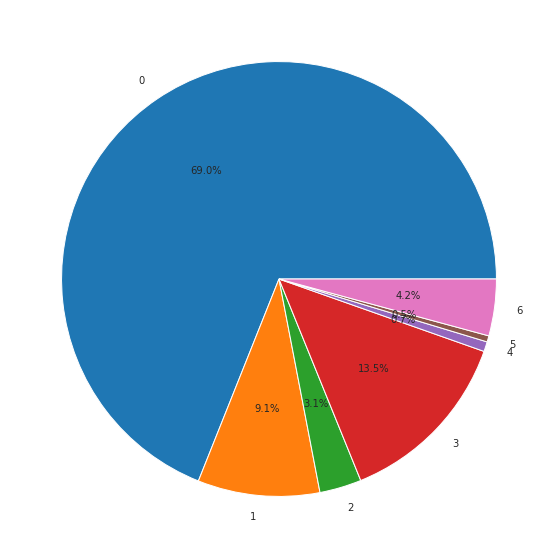

In [25]:
operator_rating_pie = operator_rating.groupby('rank').count()
#display(operator_rating_pie)

fig1, ax = plt.subplots(figsize=(10,10))

ax.pie(operator_rating_pie['operator_id'], labels=operator_rating_pie.index, autopct='%1.1f%%')
#plt.savefig('Категории операторов.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show()

* Отлично!  Более двух третей операторов совершенно добросовестно исполняют обязанности.
* Из неэффективных операторов наибольшая доля тех, кто не справляется с обзвонами
* Данных не хватило всеголишь для 4% операторов. Это хороший показатель.
* Доля операторов, не справляющихся по двум и более параметрам невелика - всего 4%
<br>
Благодаря разделению операторов по группам у заказчика будет выбор кого признавать неэффективными в первую очередь.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Неэффективных оказалось не очень много, но первый пункт вывода заставляет усомниться в этом факте.

<div class="alert alert-info"> Опечатка, поправил</div>

<a id="part4"></a>
## Проверка гипотез

### Дней в месяц
<a id="part4-1"></a>

Гипотеза: Неэффективные операторы работают меньше дней в месяц, чем эффективные.
<br> Работой буду считать любое действие за день.

In [26]:
# Выделяю номер месяца и дня из даты
telecom_data = telecom
telecom_data['month'] = pd.DatetimeIndex(telecom_data['dt_date']).month
telecom_data['days'] = pd.DatetimeIndex(telecom_data['dt_date']).day

# Проверяю нужно ли выделить год - не нужно
display(telecom_data['dt_date'].max())
display(telecom_data['dt_date'].min())

display(telecom_data.head())

# С помощью сводных таблиц считаю месяцы и дни
data_pivot = telecom_data.groupby(['operator_id','month', 'days']).count().reset_index()
display(data_pivot.head())
data_pivot = data_pivot.pivot_table(index=['operator_id','month'], values='days', aggfunc='count').reset_index()
display(data_pivot.head())
data_pivot = data_pivot.pivot_table(index='operator_id', values=['days', 'month'], aggfunc={"days": 'sum',"month":'count'}).reset_index()
display(data_pivot.head())

Timestamp('2019-11-28 00:00:00')

Timestamp('2019-08-02 00:00:00')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,dt_date,out_direction,month,days
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True,8,5
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,8,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,True,8,5
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,2019-08-05,True,8,5
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,2019-08-05,True,8,5


,operator_id,month,days,user_id,date,direction,internal,is_missed_call,calls_count,call_duration,total_call_duration,dt_date,out_direction
0,879896,8,2,3,3,3,3,3,3,3,3,3,3
1,879896,8,3,3,3,3,3,3,3,3,3,3,3
2,879896,8,4,2,2,2,2,2,2,2,2,2,2
3,879896,8,5,4,4,4,4,4,4,4,4,4,4
4,879896,8,6,5,5,5,5,5,5,5,5,5,5


,operator_id,month,days
0,879896,8,23
1,879896,9,16
2,879896,10,8
3,879896,11,3
4,879898,8,20


,operator_id,days,month
0,879896,50,4
1,879898,84,4
2,880020,14,3
3,880022,42,4
4,880026,77,4


In [27]:
# Считаю количествно дней на месяц для каждого оператора и присоединяю эту инфорамцию к таблице с рейтингом
data_pivot['days_per_month'] = (data_pivot['days'] / data_pivot['month']).round(2)
data_pivot = data_pivot.drop(['month','days'], axis=1)
display(data_pivot.head())
operator_rating = operator_rating.merge(data_pivot, on='operator_id', how='left')

,operator_id,days_per_month
0,879896,12.50
1,879898,21.00
2,880020,4.67
3,880022,10.50
4,880026,19.25


,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day,rank,days_per_month
0,880022,0.0,16.0,True,4.83,0,10.50
1,880020,0.0,7.0,True,4.86,0,4.67
2,881278,-1.0,-1.0,True,2.40,3,1.67
3,880028,0.0,7.0,True,31.91,0,19.50
4,880026,0.0,6.5,True,28.42,0,19.25


,rank,days_per_month
0,0,7.0
1,1,9.5
2,2,17.0
3,3,3.0
4,4,6.0
5,5,5.5
6,6,1.0


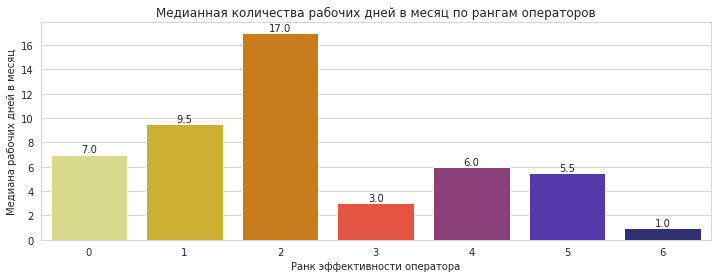

In [28]:
# Готовлю данные для построение графика
display(operator_rating.head())
rank_and_days = operator_rating.groupby('rank')['days_per_month'].median().reset_index()
display(rank_and_days)

# Строю столбчатый график
fig, ax = plt.subplots(figsize=(12, 4))
sns.set_style('whitegrid')
ct = sns.barplot(x='rank', y='days_per_month', data = rank_and_days,  palette='CMRmap_r')
ax.set_xlabel('Ранк эффективности оператора')
ax.set_ylabel('Медиана рабочих дней в месяц')
ax.set_title('Медианная количества рабочих дней в месяц по рангам операторов')
ct.bar_label(ct.containers[0], labels=rank_and_days['days_per_month'])
#plt.savefig('гипотеза 1.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

На графике зависимостей не наблюдается, но нужно проверить статистическиую значимость. Для этого сформулирую гипотезу:
<br>
<br>
H0: Количество рабочих дней в месяц у эффективных и еэффективных операторов одинаковое.<br>
Н1: Количество рабочих дней в месяц у эффективных и еэффективных операторов разное.<br>
<br>
Уровень значимости α = 0.05
Если Pvalue будет меньше этого уровня значимости, то нулевая гипотеза будет отвергнута

Для проверки буду использовать ttest_ind

In [29]:
# Готовлю данные
rank_and_days_good = operator_rating.query('rank == 0 and rank != 6')['days_per_month']
rank_and_days_bad = operator_rating.query('rank != 0 and rank != 6')['days_per_month']

alpha = .05
results = st.ttest_ind(rank_and_days_good, rank_and_days_bad)
print('p-значение: ', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.7834913262999779
Не получилось отвергнуть нулевую гипотезу


Гипотеза полностью опровергнута. В данных нет статистически значимых различий. Количество рабочих дней никак не связанно с эффективностью.

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>☁️

Проверка гипотез предполагалась статистическим тестом
</div>

### Внутренние звонки
<a id="part4-2"></a>

 Гипотеза: Неэффективные операторы чаще совершают внутренние звонки (например, чтобы уточнить что-то у коллег).

In [30]:
# Фильтрую исходящие внутренние звонки из основной таблицы и считаю их количество у каждого оператора
incalls_telecom = telecom.query('out_direction == True and internal==True')
incalls_telecom = incalls_telecom.groupby('operator_id')['calls_count'].sum().reset_index()
incalls_telecom.columns = ['operator_id', 'internal_calls_sum']
display(incalls_telecom.head())

,operator_id,internal_calls_sum
0,879896,56
1,879898,18
2,880020,4
3,880022,15
4,880026,20


In [31]:
# Присоединяю полученную информацию к таблице с рейтингом
operator_rating = operator_rating.merge(incalls_telecom, on='operator_id', how='left')

,operator_id,missed_percent,call_waiting_median,users_spec_out,calls_per_day,rank,days_per_month,internal_calls_sum
0,880022,0.0,16.0,True,4.83,0,10.50,15.0
1,880020,0.0,7.0,True,4.86,0,4.67,4.0
2,881278,-1.0,-1.0,True,2.40,3,1.67,8.0
3,880028,0.0,7.0,True,31.91,0,19.50,8.0
4,880026,0.0,6.5,True,28.42,0,19.25,20.0


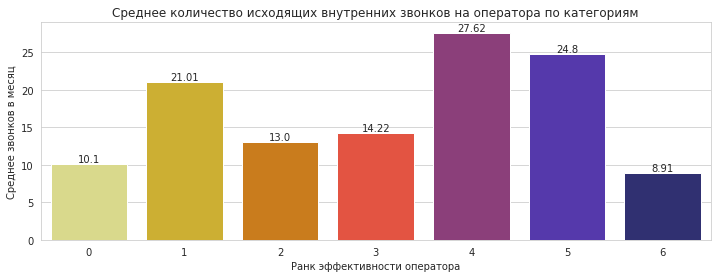

In [32]:
# Меняю пробелы в данных на нули, так как в данном случае пробелы осзначают что оператор вообще не совершал внутренних исходящх звонков
display(operator_rating.head())
operator_rating['internal_calls_sum'] = operator_rating['internal_calls_sum'].fillna(0)

# Готовлю данные для графика, считаю среднее количество звонков для ранга
ranks_intcalls = operator_rating.groupby('rank')['internal_calls_sum'].mean().reset_index().round(2)

# Строю табличку
fig, ax = plt.subplots(figsize=(12, 4))
sns.set_style('whitegrid')
ct = sns.barplot(x='rank', y='internal_calls_sum', data = ranks_intcalls,  palette='CMRmap_r')
ax.set_xlabel('Ранк эффективности оператора')
ax.set_ylabel('Среднее звонков в месяц')
ax.set_title('Среднее количество исходящих внутренних звонков на оператора по категориям')
ct.bar_label(ct.containers[0], labels=ranks_intcalls['internal_calls_sum'])
#plt.savefig('гипотеза 2.png', dpi=200.0, bbox_inches='tight', transparent=True) #Сохраняем график в файл для презентации
plt.show();

На графике видно, что самый наименьший показатель у эффективной категории. Теперь проверим. Для этого сформулирую гипотезу:
<br>
<br>
H0: Среднее количество исходящих внутренних звонков на оператора одинаковое у эффективных и неэффективных операторов.<br>
Н1: Среднее количество исходящих внутренних звонков на оператора эффективных и неэффективных операторов разное.<br>
<br>
Уровень значимости α = 0.05
Если Pvalue будет меньше этого уровня значимости, то нулевая гипотеза будет отвергнута

In [33]:
ranks_intcalls_good = operator_rating.query('rank == 0 and rank != 6')['internal_calls_sum']
ranks_intcalls_bad = operator_rating.query('rank != 0 and rank != 6')['internal_calls_sum']

alpha = .05
results = st.ttest_ind(ranks_intcalls_good, ranks_intcalls_bad)
print('p-значение: ', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.016065290110503977
Отвергаем нулевую гипотезу


Гипотеза подтверждена. В среднем неэффективные операторы звонят по внутренним линиям чаще эффективных.
Среднее я использовал так как сумма и медиана не дадут объективной информации потому что очень разные размеры выборок. Тут важна массовость явления относительно количества и среднее с этой задачей справляется.

<a id="part5"></a>
## Выводы

* Доля недобросовестных операторов составляет четверть (31%) от общего количества операторов
* Самая большая доля из неэффективных операторов у тех, кто совершает малое количество обзвонов в специализирующихся на этом колл-центрах.
* Предложена методика определения степени неэффективности операторов, что обеспечит большую свободу в принятии решений для заказчика
* Гипотеза о том, что эффективные операторы работают больше дней в месяц не подтверждена.
* Гипотеза о том, что эффективные операторы реже неэффективных звонят по внутренней линии подтверждена. Возможно это связанно с тем, что неэффективные операторы часто звонят коллегам для уточнения вопросов.

## Презентация и дашборд

Ссылки на дашборд и презентацию будут в [шапке](#start).